<a href="https://colab.research.google.com/github/haoboooo/Temporal-Generalization-of-Sentiment-Analysis-on-Amazon-Reviews/blob/main/video_games/game_merge_adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emot
!pip install -U adapter-transformers
!pip install datasets

In [ ]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

import torch
from transformers import RobertaTokenizer
import datasets
from datasets import Dataset
from transformers import RobertaConfig, RobertaModelWithHeads
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction

In [ ]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## load game data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/game/97_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/game/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/game/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/game/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(95385, 3)
 1.0    69406
-1.0    18035
 0.0     7944
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,This game is a good time. Especially if you h...
1,0.0,2005,Don't expect the bells and whistles that you f...
2,1.0,2005,"It is fun to play this game, I really like it...."
3,1.0,2006,Here's the deal with this item: it's fine for ...
4,0.0,2006,We bought this for Christmas for our three kid...


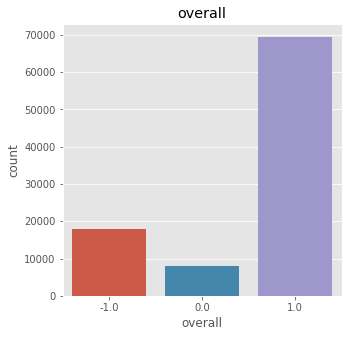

In [ ]:
# load data for 1997 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(273501, 3)
 1.0    193149
-1.0     55507
 0.0     24845
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2012,I oredered this for a daughter who is now 33 a...
1,1.0,2010,Well I thought since this idem didn't have any...
2,1.0,2012,Good game. Good graphics. A bit of a learning ...
3,-1.0,2012,"If you buy this game, you will regret it. If ..."
4,1.0,2012,4 Stars because they like it and play it often...


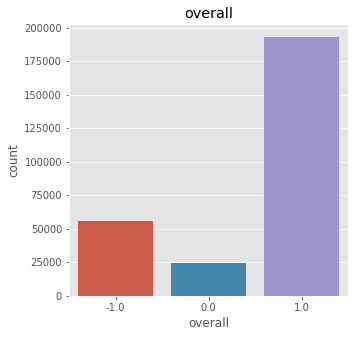

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(957163, 3)
 1.0    672584
-1.0    210099
 0.0     74480
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2014,I used to play this game years ago and loved i...
1,0.0,2014,The game itself worked great but the story lin...
2,1.0,2014,I had to learn the hard way after ordering thi...
3,-1.0,2014,The product description should state this clea...
4,1.0,2014,I would recommend this learning game for anyon...


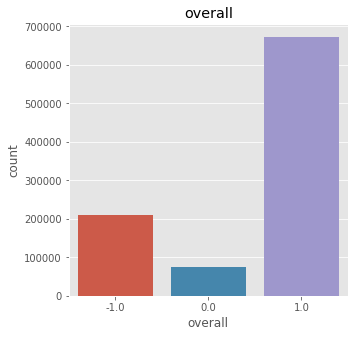

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(80396, 3)
 1.0    52744
-1.0    21618
 0.0     6034
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2018,No complaints! Sing your little heart out!
1,1.0,2018,Works great with Xbox 360. I have 2 of these u...
2,1.0,2018,The game was perfect and super clean. Very ple...
3,1.0,2018,It was perfect gift. Got it for Christmas and ...
4,1.0,2018,Lik3d it


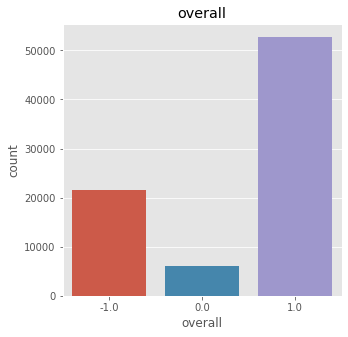

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
5000 positive，5000 negative，5000 neutral

80%(12000) training and 20%(3000) testing

In [ ]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4000,:]
  train_neudata = neu.iloc[:4000,:]
  train_negdata = neg.iloc[:4000,:]

  # split to get test for each class
  test_posdata = pos.iloc[4000:5000,:]
  test_neudata = neu.iloc[4000:5000,:]
  test_negdata = neg.iloc[4000:5000,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [ ]:
# data for 1997 - 2006
df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df2_train,df2_test = split_balance(df2)

# data for 2013 - 2017
df3_train,df3_test = split_balance(df3)

# data for 2018
df4_train,df4_test = split_balance(df4)

In [ ]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

df4_train["overall"] = df4_train["overall"].replace(-1,2)
df4_test["overall"] = df4_test["overall"].replace(-1,2)

In [ ]:
df1_train.shape

(12000, 3)

## Text Preprocessing

In [ ]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [ ]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

df4_train["cleanText"] = df4_train["reviewText"].apply(processtext)
df4_test["cleanText"] = df4_test["reviewText"].apply(processtext)

In [ ]:
df1_train.shape

(12000, 4)

## Merge train&test data

Extract 25% data from each time period and combine train&test

In [ ]:
def merge(df1,df2,df3,df4,rate):
  sample1 = df1.sample(frac=rate,replace=False,random_state=None,axis=0) # sample frac rate of rows from the dataframe without replacement
  sample2 = df2.sample(frac=rate,replace=False,random_state=None,axis=0)
  sample3 = df3.sample(frac=rate,replace=False,random_state=None,axis=0)
  sample4 = df4.sample(frac=rate,replace=False,random_state=None,axis=0)

  merged = pd.concat([sample1, sample2, sample3, sample4],sort=False).sample(frac=1.0)

  return merged

In [ ]:
def unbalanced_merge(df1,df2,df3,df4,rate1,rate2):
  sample1 = df1.sample(frac=rate1,replace=False,random_state=None,axis=0) # sample frac rate of rows from the dataframe without replacement
  sample2 = df2.sample(frac=rate2,replace=False,random_state=None,axis=0)
  sample3 = df3.sample(frac=rate2,replace=False,random_state=None,axis=0)
  sample4 = df4.sample(frac=rate2,replace=False,random_state=None,axis=0)

  merged = pd.concat([sample1, sample2, sample3, sample4],sort=False).sample(frac=1.0)

  return merged

In [ ]:
train_merged = merge(df1_train,df2_train,df3_train,df4_train,0.25)
test_merged = merge(df1_test,df2_test,df3_test,df4_test,0.25)

In [ ]:
train_merged1 = unbalanced_merge(df1_train,df2_train,df3_train,df4_train,0.4,0.2)
test_merged1 = unbalanced_merge(df1_test,df2_test,df3_test,df4_test,0.4,0.2)

In [ ]:
train_merged2 = unbalanced_merge(df1_train,df2_train,df3_train,df4_train,0.7,0.1)
test_merged2 = unbalanced_merge(df1_test,df2_test,df3_test,df4_test,0.7,0.1)

In [ ]:
df1_train.shape

(12000, 4)

In [ ]:
test_merged.shape

(3000, 4)

## Text Tokenization

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch["text"], max_length=128, truncation=True, padding="max_length")

In [ ]:
def generate_datasetdict(dataframe1,dataframe2):
  text1 = dataframe1.cleanText.values
  text2 = dataframe2.cleanText.values

  label1 = dataframe1.overall.values.astype(np.int32)
  label2 = dataframe2.overall.values.astype(np.int32)

  train_df = pd.DataFrame({"label" : label1,"text" : text1})
  test_df = pd.DataFrame({"label" : label2,"text" : text2})

  train_dataset = Dataset.from_dict(train_df)
  test_dataset = Dataset.from_dict(test_df)
  my_dataset_dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

  # Encode the input data
  dataset = my_dataset_dict.map(encode_batch, batched=True)
  # The transformers model expects the target class column to be named "labels"
  # dataset.rename_column(original_column_name="label", new_column_name="labels")
  # Transform to pytorch tensors and only output the required columns
  dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

  return dataset

In [ ]:
df1_dataset = generate_datasetdict(df1_train,df1_test)
df2_dataset = generate_datasetdict(df2_train,df2_test)
df3_dataset = generate_datasetdict(df3_train,df3_test)
df4_dataset = generate_datasetdict(df4_train,df4_test)
merge_dataset = generate_datasetdict(train_merged,test_merged)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
unbalanced_merge1 = generate_datasetdict(train_merged1,test_merged1)
unbalanced_merge2 = generate_datasetdict(train_merged2,test_merged2)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

## Train Adapters

### 25% each

In [ ]:
config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config,
)

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:255: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:233: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModelWithHeads: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModelWithHeads from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModelWithHeads from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

In [ ]:
# Add a new adapter
model.add_adapter("merged_review")
# Add a matching classification head
model.add_classification_head(
    "merged_review",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
model.train_adapter("merged_review")

In [ ]:
training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=200,
    output_dir="./training_output",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

def compute_accuracy(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  return {"acc": (preds == p.label_ids).mean()}

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=merge_dataset["train"],
    eval_dataset=merge_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.942700
400,0.792400
600,0.764100
800,0.734200
1000,0.730400
1200,0.703400
1400,0.702100
1600,0.673600
1800,0.686900
2000,0.667600


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/merged_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/merged_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/merged_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/merged_review/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/merged_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/merged_review/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/merged_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/merged_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/merged_review/head_config.json
Module weights saved in ./training_output/checkpoint-1000/merged_

TrainOutput(global_step=2250, training_loss=0.731737547132704, metrics={'train_runtime': 603.2328, 'train_samples_per_second': 119.357, 'train_steps_per_second': 3.73, 'total_flos': 4818162714624000.0, 'train_loss': 0.731737547132704, 'epoch': 6.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.6803333333333333,
 'eval_loss': 0.7294111251831055,
 'eval_runtime': 12.6337,
 'eval_samples_per_second': 237.459,
 'eval_steps_per_second': 7.44}

In [ ]:
trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.25901845, -1.9475601 ,  1.0227621 ],
       [ 1.4937502 , -1.8472629 , -0.21960028],
       [ 0.5444546 , -3.6275492 ,  2.3981974 ],
       ...,
       [-0.09783942, -2.4751377 ,  2.1055138 ],
       [-0.35146967,  2.6566405 , -2.666988  ],
       [-0.45323902, -2.0651248 ,  2.1304717 ]], dtype=float32), label_ids=array([2, 0, 0, ..., 2, 1, 2]), metrics={'test_loss': 0.7242944240570068, 'test_acc': 0.697, 'test_runtime': 12.6556, 'test_samples_per_second': 237.049, 'test_steps_per_second': 7.428})

In [ ]:
trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-0.16058527, -3.55272   ,  3.1615784 ],
       [-0.5140584 ,  2.8323274 , -2.7258532 ],
       [ 0.59639645, -2.5503159 ,  1.5135458 ],
       ...,
       [-0.05337572, -2.3184044 ,  1.9448851 ],
       [-0.04684546, -3.0818439 ,  2.528886  ],
       [-0.39283168,  0.61040044, -0.7265162 ]], dtype=float32), label_ids=array([2, 1, 2, ..., 2, 2, 0]), metrics={'test_loss': 0.7233631014823914, 'test_acc': 0.685, 'test_runtime': 12.654, 'test_samples_per_second': 237.079, 'test_steps_per_second': 7.428})

In [ ]:
trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-0.8091063 ,  3.2731044 , -2.7395022 ],
       [ 0.05393443, -3.477116  ,  2.9808486 ],
       [-0.5650852 , -2.3661842 ,  2.7549968 ],
       ...,
       [-0.3242013 ,  3.365569  , -3.1656091 ],
       [ 0.7307561 , -2.5365376 ,  1.0397029 ],
       [-1.1849879 ,  3.656769  , -2.6282558 ]], dtype=float32), label_ids=array([1, 2, 2, ..., 0, 0, 1]), metrics={'test_loss': 0.7010636925697327, 'test_acc': 0.687, 'test_runtime': 12.6894, 'test_samples_per_second': 236.418, 'test_steps_per_second': 7.408})

In [ ]:
trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-1.2077663 ,  2.9459968 , -1.9472756 ],
       [ 0.62858397,  1.0032865 , -1.9659743 ],
       [ 1.269341  , -2.4951096 ,  0.7358017 ],
       ...,
       [ 1.2969705 , -2.2232537 ,  0.21847172],
       [-0.8932176 , -2.6336317 ,  3.1751244 ],
       [ 0.24261738,  1.441081  , -1.921361  ]], dtype=float32), label_ids=array([1, 0, 2, ..., 2, 2, 1]), metrics={'test_loss': 0.6770353317260742, 'test_acc': 0.6946666666666667, 'test_runtime': 12.6729, 'test_samples_per_second': 236.726, 'test_steps_per_second': 7.417})

### 4:2:2:2

In [ ]:
config_unbld1 = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model_unbld1 = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config_unbld1,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [ ]:
# Add a new adapter
model_unbld1.add_adapter("unbalance_merged_review1")
# Add a matching classification head
model_unbld1.add_classification_head(
    "unbalance_merged_review1",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
model_unbld1.train_adapter("unbalance_merged_review1")

Adding adapter 'unbalance_merged_review1'.
Adding head 'unbalance_merged_review1' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'neutral': 0, 'positive': 1, 'negative': 2}, 'use_pooler': False, 'bias': True}.


In [ ]:
trainer_unbld1 = AdapterTrainer(
    model=model_unbld1,
    args=training_args,
    train_dataset=unbalanced_merge1["train"],
    eval_dataset=unbalanced_merge1["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
trainer_unbld1.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.950700
400,0.801300
600,0.751100
800,0.736400
1000,0.717000
1200,0.709100
1400,0.692000
1600,0.680900
1800,0.669200
2000,0.667400


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/unbalance_merged_review1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/unbalance_merged_review1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/unbalance_merged_review1/head_config.json
Module weights saved in ./training_output/checkpoint-500/unbalance_merged_review1/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/unbalance_merged_review1/head_config.json
Module weights saved in ./training_output/checkpoint-500/unbalance_merged_review1/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/unbalance_merged_review1/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/unbalance_merged_review1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/unbalanc

TrainOutput(global_step=2250, training_loss=0.7294993608262804, metrics={'train_runtime': 602.8918, 'train_samples_per_second': 119.424, 'train_steps_per_second': 3.732, 'total_flos': 4818162714624000.0, 'train_loss': 0.7294993608262804, 'epoch': 6.0})

In [ ]:
trainer_unbld1.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.6946666666666667,
 'eval_loss': 0.7020983099937439,
 'eval_runtime': 12.6167,
 'eval_samples_per_second': 237.78,
 'eval_steps_per_second': 7.45}

In [ ]:
trainer_unbld1.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.603901  , -2.0774138 ,  1.3798888 ],
       [ 1.7318239 , -1.100259  , -0.40470114],
       [ 0.6846636 , -4.005655  ,  3.2743282 ],
       ...,
       [ 0.37824017, -2.1440415 ,  1.8880265 ],
       [-0.13547511,  3.185716  , -2.9355292 ],
       [-0.154681  , -1.8955457 ,  2.2036011 ]], dtype=float32), label_ids=array([2, 0, 0, ..., 2, 1, 2]), metrics={'test_loss': 0.716007649898529, 'test_acc': 0.693, 'test_runtime': 12.6159, 'test_samples_per_second': 237.796, 'test_steps_per_second': 7.451})

In [ ]:
trainer_unbld1.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.14029865, -3.5732243 ,  3.4464922 ],
       [-0.4272905 ,  2.822658  , -1.9907802 ],
       [ 0.8026596 , -1.6599685 ,  0.8542508 ],
       ...,
       [ 0.24343334, -0.9521487 ,  0.71447045],
       [ 0.22274974, -2.5708578 ,  2.4247642 ],
       [ 0.20448421,  0.6955565 , -0.5939384 ]], dtype=float32), label_ids=array([2, 1, 2, ..., 2, 2, 0]), metrics={'test_loss': 0.7346557378768921, 'test_acc': 0.6796666666666666, 'test_runtime': 12.6078, 'test_samples_per_second': 237.948, 'test_steps_per_second': 7.456})

In [ ]:
trainer_unbld1.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-0.17835695,  2.7282073 , -2.2081814 ],
       [ 0.08251495, -3.245531  ,  2.9262915 ],
       [-0.4802651 , -2.3228662 ,  2.8185015 ],
       ...,
       [-0.58165973,  3.6837869 , -2.6487322 ],
       [ 1.3307881 , -2.8603432 ,  1.7315482 ],
       [-1.3403972 ,  3.670682  , -1.9891436 ]], dtype=float32), label_ids=array([1, 2, 2, ..., 0, 0, 1]), metrics={'test_loss': 0.7113184332847595, 'test_acc': 0.6936666666666667, 'test_runtime': 12.618, 'test_samples_per_second': 237.757, 'test_steps_per_second': 7.45})

In [ ]:
trainer_unbld1.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-1.3393848 ,  3.7712545 , -2.0461988 ],
       [ 0.29715213,  2.0063024 , -2.1393201 ],
       [ 1.4506574 , -2.795381  ,  1.470178  ],
       ...,
       [ 1.6673708 , -1.7016753 , -0.02240334],
       [-0.81940204, -3.144174  ,  3.807115  ],
       [ 0.22485955,  1.9341847 , -2.030836  ]], dtype=float32), label_ids=array([1, 0, 2, ..., 2, 2, 1]), metrics={'test_loss': 0.7015445828437805, 'test_acc': 0.6933333333333334, 'test_runtime': 12.6234, 'test_samples_per_second': 237.654, 'test_steps_per_second': 7.446})

### 7:1:1:1

In [ ]:
config_unbld2 = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model_unbld2 = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config_unbld2,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [ ]:
# Add a new adapter
model_unbld2.add_adapter("unbalance_merged_review2")
# Add a matching classification head
model_unbld2.add_classification_head(
    "unbalance_merged_review2",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
model_unbld2.train_adapter("unbalance_merged_review2")

Adding adapter 'unbalance_merged_review2'.
Adding head 'unbalance_merged_review2' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'neutral': 0, 'positive': 1, 'negative': 2}, 'use_pooler': False, 'bias': True}.


In [ ]:
trainer_unbld2 = AdapterTrainer(
    model=model_unbld2,
    args=training_args,
    train_dataset=unbalanced_merge2["train"],
    eval_dataset=unbalanced_merge2["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
trainer_unbld2.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.960500
400,0.829900
600,0.774600
800,0.760600
1000,0.743700
1200,0.727600
1400,0.725400
1600,0.693000
1800,0.692800
2000,0.690300


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/unbalance_merged_review2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/unbalance_merged_review2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/unbalance_merged_review2/head_config.json
Module weights saved in ./training_output/checkpoint-500/unbalance_merged_review2/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/unbalance_merged_review2/head_config.json
Module weights saved in ./training_output/checkpoint-500/unbalance_merged_review2/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/unbalance_merged_review2/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/unbalance_merged_review2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/unbalanc

TrainOutput(global_step=2250, training_loss=0.7516870507134331, metrics={'train_runtime': 602.0708, 'train_samples_per_second': 119.587, 'train_steps_per_second': 3.737, 'total_flos': 4818162714624000.0, 'train_loss': 0.7516870507134331, 'epoch': 6.0})

In [ ]:
trainer_unbld2.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.6956666666666667,
 'eval_loss': 0.7024460434913635,
 'eval_runtime': 12.6102,
 'eval_samples_per_second': 237.902,
 'eval_steps_per_second': 7.454}

In [ ]:
trainer_unbld2.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.4733143 , -2.1250632 ,  1.5827134 ],
       [ 1.7306626 , -1.1081116 , -0.31168416],
       [ 1.1092473 , -3.532262  ,  2.4214365 ],
       ...,
       [ 0.07871234, -2.4526155 ,  2.4806547 ],
       [ 0.01277447,  2.778626  , -2.5253193 ],
       [-0.18859924, -1.7233995 ,  1.9744332 ]], dtype=float32), label_ids=array([2, 0, 0, ..., 2, 1, 2]), metrics={'test_loss': 0.7078699469566345, 'test_acc': 0.6983333333333334, 'test_runtime': 12.5926, 'test_samples_per_second': 238.235, 'test_steps_per_second': 7.465})

In [ ]:
trainer_unbld2.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-0.08824711, -3.0534525 ,  3.0725298 ],
       [-0.19974416,  3.0715187 , -2.3374138 ],
       [ 0.71115005, -1.8956383 ,  1.2243279 ],
       ...,
       [ 0.17128907, -0.520283  ,  0.33074915],
       [ 0.05402979, -2.3577583 ,  2.3112936 ],
       [ 0.31331804,  1.0176995 , -0.8847471 ]], dtype=float32), label_ids=array([2, 1, 2, ..., 2, 2, 0]), metrics={'test_loss': 0.7226178646087646, 'test_acc': 0.678, 'test_runtime': 12.6374, 'test_samples_per_second': 237.391, 'test_steps_per_second': 7.438})

In [ ]:
trainer_unbld2.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-0.5058742 ,  3.1315217 , -2.182302  ],
       [-0.08804578, -2.748413  ,  2.5712175 ],
       [-0.6075204 , -1.9074897 ,  2.5382905 ],
       ...,
       [-0.1663667 ,  2.8878915 , -2.3421211 ],
       [ 0.5362763 , -2.092684  ,  1.7148997 ],
       [-0.8038175 ,  3.6161869 , -2.4648888 ]], dtype=float32), label_ids=array([1, 2, 2, ..., 0, 0, 1]), metrics={'test_loss': 0.7242921590805054, 'test_acc': 0.6723333333333333, 'test_runtime': 12.6368, 'test_samples_per_second': 237.401, 'test_steps_per_second': 7.439})

In [ ]:
trainer_unbld2.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-0.84170276,  3.282953  , -2.005692  ],
       [ 1.0361017 ,  0.562078  , -1.450137  ],
       [ 0.7547137 , -2.485239  ,  1.8080761 ],
       ...,
       [ 1.4561057 , -1.4463819 ,  0.00904452],
       [-1.3617705 , -2.2774994 ,  3.4778874 ],
       [ 0.46751666,  1.6052471 , -1.8519112 ]], dtype=float32), label_ids=array([1, 0, 2, ..., 2, 2, 1]), metrics={'test_loss': 0.7145676016807556, 'test_acc': 0.6843333333333333, 'test_runtime': 12.6267, 'test_samples_per_second': 237.592, 'test_steps_per_second': 7.445})